In [25]:
from dataprocess import *
from vqc import encode_RealAmplitudes,ansatz_circuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import QuantumCircuit
from qiskit_machine_learning.algorithms import VQC
import math
import stim
import json
import hypermapper
import sys
import logging
import random
import numpy as np
from circuit_manipulation import qiskit_to_stim,transform_to_allowed_gates

In [2]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit import QuantumCircuit
import numpy as np
import stim

def transform_to_allowed_gates(circuit, **kwargs):
    """
    circuit (QuantumCircuit): Circuit with only Clifford gates (1q rotations Ry, Rz must be k*pi/2).
    kwargs (Dict): All the arguments that need to be passed on to the next function calls.
    
    Returns:
    (QuantumCircuit) Logically equivalent circuit but with gates in required format (no Ry, Rz gates; only S, Sdg, H, X, Z).
    """
    dag = circuit_to_dag(circuit)
    
    threshold = 1e-3
    # we will substitute nodes inplace
    for node in dag.op_nodes():
        #print("#######")
        #print(node.op)
        qc_loc = QuantumCircuit(1)
        if node.name == "ry":
            angle = float(node.op.params[0])
            
            # substitute gates
            if abs(angle - 0) < threshold:
                dag.remove_op_node(node)
            elif abs(angle - np.pi/2) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.sdg(0)
                qc_loc.sx(0)
                qc_loc.s(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace = True)
            elif abs(angle - np.pi) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.y(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace=True)
            elif abs(angle + 0.5*np.pi) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.sdg(0)
                qc_loc.sxdg(0)
                qc_loc.s(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace = True)
        elif node.name == 'rz':
            angle = float(node.op.params[0])
            #substitute gates
            if abs(angle - 0) < threshold:
                dag.remove_op_node(node)
            elif abs(angle - np.pi/2) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.s(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace=True)
            elif abs(angle - np.pi) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.z(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace=True)
            elif abs(angle + 0.5*np.pi) < threshold:
                #qc_loc = QuantumCircuit(1)
                qc_loc.sdg(0)
                qc_loc_instr = qc_loc.to_instruction()
                dag.substitute_node(node, qc_loc_instr, inplace=True)
        elif node.name == "x":
            #print("@@@@")
            #qc_loc = QuantumCircuit(1)
            qc_loc.x(0)
            qc_loc_instr = qc_loc.to_instruction()
            #print(qc_loc_instr)
            dag.substitute_node(node, qc_loc_instr, inplace=True)
        
        elif node.name == "y":
            #print("@@@@")
            #qc_loc = QuantumCircuit(1)
            qc_loc.y(0)
            qc_loc_instr = qc_loc.to_instruction()
            #print(qc_loc_instr)
            dag.substitute_node(node, qc_loc_instr, inplace=True)
        
        elif node.name == "z":
            #print("@@@@")
            #qc_loc = QuantumCircuit(1)
            qc_loc.z(0)
            qc_loc_instr = qc_loc.to_instruction()
            #print(qc_loc_instr)
            dag.substitute_node(node, qc_loc_instr, inplace=True)
    return dag_to_circuit(dag)

def qiskit_to_stim(circuit):
    """
    Transform Qiskit QuantumCircuit into stim circuit.
    circuit (QuantumCircuit): Clifford-only circuit.

    Returns:
    (stim._stim_sse2.Circuit) stim circuit.
    """
    #print(type(circuit))
    assert isinstance(circuit, QuantumCircuit), f"Circuit is not a Qiskit QuantumCircuit."
    allowed_gates = ["X", "Y", "Z", "H", "CX", "S", "S_DAG", "SQRT_X", "SQRT_X_DAG"]
    stim_circ = stim.Circuit()
    # make sure right number of qubits in stim circ
    for i in range(circuit.num_qubits):
        stim_circ.append("I", [i])
    
  
    for instruction in circuit:
        #print(type(instruction))
        gate_lbl = instruction.operation.name.upper()
        if gate_lbl == "BARRIER":
            continue
        elif gate_lbl == "SDG":
            gate_lbl = "S_DAG"
        elif gate_lbl == "SX":
            gate_lbl = "SQRT_X"
        elif gate_lbl == "SXDG":
            gate_lbl = "SQRT_X_DAG"
        assert gate_lbl in allowed_gates, f"Invalid gate {gate_lbl}."
        qubit_idc = [qb._index for qb in instruction.qubits]
        stim_circ.append(gate_lbl, qubit_idc)
    return stim_circ


In [3]:
def encode_circuit(input_params,qubit_num,clifford_group=["I","x","y","z"]):
    #print(input_params)
    encode_qc=QuantumCircuit(qubit_num)
    for i,item in enumerate(input_params):
        #后续还是要考虑一下cliiford更大的时候怎么搞
        #print(item)
        for gate_index in item:
            
            if gate_index=="1":
                encode_qc.x(i)
            elif gate_index=="2":
                encode_qc.y(i)
            elif gate_index=="3":
                encode_qc.z(i)
    return encode_qc


In [4]:
qc_loc = QuantumCircuit(1)
qc_loc.sdg(0)
qc_loc_instr = qc_loc.to_instruction()
print(qc_loc_instr)

Instruction(name='circuit-152', num_qubits=1, num_clbits=0, params=[])


In [7]:
ansatz,num =ansatz_circuit(2,ansatz_reps=1)
guess_params= [random.randint(-1, 2)*math.pi/2 for _ in range(num)]
length = 13
elements = ['X', 'Y', 'Z']

random_string = ''.join(random.choice(elements) for _ in range(length))


In [32]:
def self_make_data(n_samples=7,n_features=3,n_classes=2,n_train=6):
    
    X, y = make_classification(
        n_samples=n_samples,     # 样本数量
        n_features=n_features,      # 特征数量
        n_informative=2,   # 有用特征数量
        n_redundant=0,     # 冗余特征数量
        n_clusters_per_class=1,
        n_classes=n_classes,       # 分类数量
        random_state=42    # 随机种子
    )
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X[:n_train],y[:n_train],n_features,X[n_train:],y[n_train:]
data_train,target_train,feature_num,data_test,target_test=self_make_data()

In [33]:
import sys
from train_func import mse_loss
import random
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit import  execute
from qiskit_aer import Aer
from qiskit.primitives import Estimator
from qiskit.quantum_info import Pauli

print(data_train)
def Estimator_(circuit):
    backend = Aer.get_backend('qasm_simulator')
    shots = 1000  # 选择你希望的测量次数

    # 添加测量操作
    circuit.measure_all()

    # 执行电路并获取结果
    job = execute(circuit, backend, shots=1)
    result = job.result()

    # 获取测量结果
    counts = result.get_counts(circuit)
    
    # 返回测量结果
    return counts

loss=0
for i in range(len(data_train)):
    print(data_train[i])
    encoded_circuit=encode_RealAmplitudes(data_train[i],qubit_num=3)
    print(encoded_circuit)
    ansatz,num =ansatz_circuit(3,ansatz_reps=3)
    ansatz=ansatz.assign_parameters([3.141592653589793/2]*num)
    
    ansatz=ansatz.decompose()
    
    vqc_cir=QuantumCircuit(3)
    vqc_cir.compose(encoded_circuit,inplace=True)
    vqc_cir.compose(ansatz,inplace=True)
    print(vqc_cir)
    result=Estimator_(vqc_cir)
    print(result)
    loss+=mse_loss(result[1][0],target_train[i])
    #print(result,target_train[i])
    #print(mse_loss(result,target_train[i]))
    
print(loss)
    

[[0.14448745 0.         0.        ]
 [0.         0.29818498 0.39733687]
 [0.77669965 0.67687213 0.36048858]
 [0.0436026  0.97592405 1.        ]
 [0.14744734 1.         0.82656915]
 [0.82338756 0.21834734 0.35978908]]
[0.14448745 0.         0.        ]
     ┌──────────┐                 ┌──────────┐
q_0: ┤ Ry(-π/2) ├──────────■──────┤ Ry(-π/2) ├
     ├──────────┤        ┌─┴─┐    ├──────────┤
q_1: ┤ Ry(-π/2) ├──■─────┤ X ├────┤ Ry(-π/2) ├
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘
q_2: ┤ Ry(-π/2) ├┤ X ├┤ Ry(-π/2) ├────────────
     └──────────┘└───┘└──────────┘            
     ┌──────────┐                 ┌──────────┐┌─────────┐┌─────────┐┌───┐     »
q_0: ┤ Ry(-π/2) ├──────────■──────┤ Ry(-π/2) ├┤ Ry(π/2) ├┤ Rz(π/2) ├┤ X ├──■──»
     ├──────────┤        ┌─┴─┐    ├──────────┤├─────────┤├─────────┤└─┬─┘┌─┴─┐»
q_1: ┤ Ry(-π/2) ├──■─────┤ X ├────┤ Ry(-π/2) ├┤ Ry(π/2) ├┤ Rz(π/2) ├──┼──┤ X ├»
     ├──────────┤┌─┴─┐┌──┴───┴───┐├─────────┬┘├─────────┤└─────────┘  │  └───┘»
q_2: ┤ Ry(-π/2) ├┤ 

KeyError: 1

In [71]:
loss=0
for i in range(4,7):
    
    encoded_circuit=encode_circuit(input_params[i],qubit_num=4)
    
    ansatz,num =ansatz_circuit(4,ansatz_reps=3)
    ansatz=ansatz.assign_parameters([0]*num)
    
    ansatz=ansatz.decompose()
    
    vqc_cir=QuantumCircuit(4)
    vqc_cir.compose(encoded_circuit,inplace=True)
    vqc_cir.compose(ansatz,inplace=True)
    print(vqc_cir)
    result=Estimator_(vqc_cir)
    print(result)
    loss+=mse_loss(result[1][0],target_train[i])
    #print(result,target_train[i])
    #print(mse_loss(result,target_train[i]))
    
print(loss)

     ┌───┐┌───┐  ┌───┐  ┌───────┐┌───┐     ┌───────┐                  ┌───┐»
q_0: ┤ X ├┤ Z ├──┤ Y ├──┤ Rz(0) ├┤ X ├──■──┤ Rz(0) ├──────────────────┤ X ├»
     ├───┤├───┤┌─┴───┴─┐└───────┘└─┬─┘┌─┴─┐└───────┘┌───────┐         └─┬─┘»
q_1: ┤ Z ├┤ X ├┤ Rz(0) ├───────────┼──┤ X ├────■────┤ Rz(0) ├───────────┼──»
     ├───┤├───┤└─┬───┬─┘┌───────┐  │  └───┘  ┌─┴─┐  └───────┘┌───────┐  │  »
q_2: ┤ Y ├┤ Z ├──┤ X ├──┤ Rz(0) ├──┼─────────┤ X ├──────■────┤ Rz(0) ├──┼──»
     ├───┤├───┤  ├───┤  ├───────┤  │         └───┘    ┌─┴─┐  ├───────┤  │  »
q_3: ┤ Y ├┤ X ├──┤ X ├──┤ Rz(0) ├──■──────────────────┤ X ├──┤ Rz(0) ├──■──»
     └───┘└───┘  └───┘  └───────┘                     └───┘  └───────┘     »
«          ┌───────┐                  ┌───┐     ┌───────┐                  
«q_0: ──■──┤ Rz(0) ├──────────────────┤ X ├──■──┤ Rz(0) ├──────────────────
«     ┌─┴─┐└───────┘┌───────┐         └─┬─┘┌─┴─┐└───────┘┌───────┐         
«q_1: ┤ X ├────■────┤ Rz(0) ├───────────┼──┤ X ├────■────┤ Rz(0) ├─────────
«  

In [41]:
len(data_train)

80

In [27]:
print(180/len(data_train))

2.25


In [67]:
ansatz,num =ansatz_circuit(4,ansatz_reps=3)
guess_params= [random.randint(-1, 2)*math.pi/2 for _ in range(num)]
guess_params=[0]*num


[1.5707963267948966, 3.141592653589793, -1.5707963267948966, 3.141592653589793, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, -1.5707963267948966, 3.141592653589793, 3.141592653589793, 3.141592653589793, -1.5707963267948966, -1.5707963267948966, 0.0, 3.141592653589793, 1.5707963267948966, -1.5707963267948966, 0.0, 1.5707963267948966, 1.5707963267948966, 3.141592653589793, -1.5707963267948966, 3.141592653589793, 1.5707963267948966, -1.5707963267948966, 0.0, 1.5707963267948966, 1.5707963267948966, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 0.0, 0.0, -1.5707963267948966, 1.5707963267948966, 0.0, 1.5707963267948966, -1.5707963267948966, 1.5707963267948966, 1.5707963267948966, -1.5707963267948966, 3.141592653589793, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 0.0, 0.0, 3.141592653589793, 3.141592653589793, -1.5707963267948966, -1.5707963267948966, 3.141592653589793, 3.141592653589793, 3.1415926

In [70]:

clif=transform_to_allowed_gates(vqc_cir).decompose()
print(clif)
cir=qiskit_to_stim(clif)

sim = stim.TableauSimulator()
sim.do_circuit(cir)
expection_val=sim.peek_observable_expectation(stim.PauliString("Z"*13))
print(expection_val)


length = 13
elements = ['I', 'X', 'Y', 'Z']

# 生成长度为13的随机字符串
random_string = ''.join(random.choice(elements) for _ in range(length))

#for i in range(10):
    #random_string = ''.join(random.choice(elements) for _ in range(length))
    #print(random_string)
    #expection_val=sim.peek_observable_expectation(stim.PauliString(random_string))
    #print(expection_val)
    #sim_1 = stim.TableauSimulator()
    #expection_val=sim_1.peek_observable_expectation(stim.PauliString("Z"))
    #print(expection_val)
#sim_1 = stim.TableauSimulator()
#expection_val=sim_1.peek_observable_expectation(stim.PauliString("IZ"))
#print(expection_val)


      ┌─────┐ ┌────┐ ┌───┐┌─────┐┌───┐     ┌───┐                            »
 q_0: ┤ Sdg ├─┤ √X ├─┤ S ├┤ Sdg ├┤ X ├──■──┤ S ├────────────────────────────»
      └┬───┬┘ └────┘ └───┘└─────┘└─┬─┘┌─┴─┐└───┘┌─────┐ ┌────┐ ┌───┐        »
 q_1: ─┤ Y ├───────────────────────┼──┤ X ├──■──┤ Sdg ├─┤ √X ├─┤ S ├────────»
      ┌┴───┴┐┌──────┐┌───┐ ┌───┐   │  └───┘┌─┴─┐└─────┘┌┴────┤ ├───┴┐ ┌───┐ »
 q_2: ┤ Sdg ├┤ √Xdg ├┤ S ├─┤ Z ├───┼───────┤ X ├───■───┤ Sdg ├─┤ √X ├─┤ S ├─»
      └┬───┬┘└┬───┬─┘└───┘ └───┘   │       └───┘ ┌─┴─┐ └─────┘┌┴────┤ └───┘ »
 q_3: ─┤ Y ├──┤ S ├────────────────┼─────────────┤ X ├────■───┤ Sdg ├───────»
      ┌┴───┴┐ ├───┴┐ ┌───┐┌─────┐  │             └───┘  ┌─┴─┐ └─────┘┌─────┐»
 q_4: ┤ Sdg ├─┤ √X ├─┤ S ├┤ Sdg ├──┼────────────────────┤ X ├────■───┤ Sdg ├»
      └─────┘ └────┘ └───┘└─────┘  │                    └───┘  ┌─┴─┐ └─────┘»
 q_5: ─────────────────────────────┼───────────────────────────┤ X ├────■───»
      ┌─────┐ ┌────┐ ┌───┐ ┌───┐   │                           └

In [26]:
import stim
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
#circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
#circuit.append("M", [0, 1])

In [8]:
circuit.diagram()

q0: -H-@-
       |
q1: ---X-

In [29]:
sim = stim.TableauSimulator()
sim.do_circuit(circuit)
observable="IZ"
expection_val=sim.peek_observable_expectation(stim.PauliString(observable))
print(expection_val)

1


In [9]:
from qiskit.circuit.library import RealAmplitudes
 
features = [0.2, 0.4, 0.8]*2
feature_map = RealAmplitudes(3, reps=2) .decompose()
 
encoded = feature_map.assign_parameters(features).decompose()
print(encoded)
encoded.draw("mpl")

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [11]:
from qiskit.circuit.library import RealAmplitudes

encode_qc=RealAmplitudes(5,reps=1,entanglement="linear").decompose()

In [12]:
print(encode_qc)
#print(encode_qc.num_parameters)

     ┌──────────┐     ┌──────────┐                                    
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├────────────────────────────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐                        
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[6]) ├────────────────────────
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──────────┐            
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────────────
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘┌──────────┐
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├─────────■──────┤ Ry(θ[8]) ├
     ├──────────┤                    └───┘       ┌─┴─┐    ├──────────┤
q_4: ┤ Ry(θ[4]) ├────────────────────────────────┤ X ├────┤ Ry(θ[9]) ├
     └──────────┘                                └───┘    └──────────┘


In [26]:
from qiskit.circuit.library import EfficientSU2

encode_qc=EfficientSU2(10,reps=4).decompose()
print(encode_qc.num_parameters)
print(encode_qc)

100
     ┌──────────┐┌───────────┐                                            »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[10]) ├────────────────────────────────────────────»
     ├──────────┤├───────────┤                                            »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[11]) ├────────────────────────────────────────────»
     ├──────────┤├───────────┤                                            »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[12]) ├────────────────────────────────────────────»
     ├──────────┤├───────────┤                                            »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[13]) ├────────────────────────────────────────────»
     ├──────────┤├───────────┤                                            »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[14]) ├────────────────────────────────────────────»
     ├──────────┤├───────────┤                                            »
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[15]) ├─────────────────────────────────────■──────»
     ├──────────┤├───────────┤                                   ┌─┴─┐    »
q_6: ┤ R

In [1]:
from vqc import *

In [2]:
def generate_observables_list(n,sampled_index=None): 
    if sampled_index==None:
        sampled_index=list(range(0, 4**n))
        
    observables_list=[]
    Paulis = ["X","Y","Z","I"]
    
    for i in sampled_index:
        
        binary_str =decimal_to_quaternary(i).zfill(n)
        xyzistr = [Paulis[int(b)] for k,b in enumerate(binary_str)]
        XYZI=""
        #print(xyzistr)
        for j in range(n):
            XYZI+=xyzistr[j]
        observables_list.append(XYZI)
    return observables_list

In [12]:
def sample_single(n):
    qc = QuantumCircuit(n)

    #for qubit in range(n):
    #    qc.rz(np.pi, qubit)
    #    qc.ry(np.pi/2, qubit)

    # 构建 EfficientSU2 ansatz
    ansatz=EfficientSU2(n, su2_gates=['ry','rz'], parameter_prefix='x',entanglement='circular', reps=3)

    params_num= ansatz.num_parameters
    #print(params_num)
    sample_list=[random.choice([0, 1.570796327, 3.141592654, -1.570796327]) for _ in range(params_num)]
    ansatz=ansatz.assign_parameters(sample_list).decompose()
    # 将 ansatz 附加到我们的量子电路中
    qc.compose(ansatz, inplace=True)

    
    
    #print(ansatz)
    vqc_clif=transform_to_allowed_gates(qc)
    vqc_stim=qiskit_to_stim(vqc_clif)

    sim = stim.TableauSimulator()
    sim.do_circuit(vqc_stim)
    total_range = 4**n
    if n<=10:
        sample_size=4**n
        sampled_numbers=range(0,4**n)
    else:
        sample_size = 1000
        # If the range is too large, you can split the process into manageable chunks
        chunk_size = int(1e6)  # Adjust based on memory constraints
        sampled_numbers = []
        while len(sampled_numbers) < sample_size:
            chunk_start = random.randint(0, total_range - chunk_size)
            chunk = range(chunk_start, min(chunk_start + chunk_size, total_range))
            sampled_numbers.extend(random.sample(list(chunk), min(sample_size - len(sampled_numbers), chunk_size)))

    observable=generate_observables_list(n,sampled_numbers)
    #print(observable)
    params = np.random.rand(len(observable))

    expection_val1=[sim.peek_observable_expectation(stim.PauliString(item)) for item in observable]
    #print(expection_val1)
    result=np.dot(expection_val1,params)
    return result

In [121]:
from itertools import product

def generate_strings(n):
    # 使用itertools.product生成所有长度为n的I和Z的组合
    combinations = product('IZ', repeat=n)
    # 将生成的组合转换为字符串并存储在列表中
    result = [''.join(combination) for combination in combinations]
    return result

# 示例使用
n = 3  # 你可以更改n的值以生成不同长度的字符串
generated_list = generate_strings(4)

# 打印生成的列表
print(f"Generated {len(generated_list)} strings of length {n}:")
print(generated_list)


Generated 16 strings of length 3:
['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ']


In [6]:
sample_single(3)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


0.8111440468256632

In [8]:
def sample_n_qubit(n):
    sample_result=[]
    for i in range(2000):
        sample_result.append(sample_single(n))
    return sample_result

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# 绘制合并后的数据
plt.plot(sample_result)
# 设置图表标题和标签
plt.title('parallel sample, 10 qubit, 100 data, use hm, revser_linear,rep=20,40min')

plt.ylabel('Value')
plt.grid()

# 显示图表
plt.show()

In [17]:

for i in range(2,30):
    print(i)
    with open("D:\\QML\\QML_Cliiford\\samples.csv","a") as file:
        writer = csv.writer(file)
        writer.writerow(sample_n_qubit(i))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [28]:
import csv
import matplotlib.pyplot as plt

def count_zeros_per_row(csv_filename):
    counts = []
    with open(csv_filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            count = row.count('0')
            counts.append(count)
    
    counts = counts[::2]
    print(counts)
    return counts




# Replace 'your_file.csv' with your actual CSV file name
csv_filename ="D:\\QML\\QML_Cliiford\\count_2_30.csv"
counts = count_zeros_per_row(csv_filename)
print(counts)
plt.clf()
plt.plot(counts, marker='o')
plt.xlabel('Row Index')
plt.ylabel('Number of Zeros')
plt.title('Number of Zeros per Row in CSV')
plt.grid(True)


plt.savefig('plot.png')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1238, 1555, 1777, 1899, 1941, 1973, 1987, 1993, 1996, 1997, 2000, 1999, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1238, 1555, 1777, 1899, 1941, 1973, 1987, 1993, 1996, 1997, 2000, 1999, 2000, 2000, 2000, 2000, 2000, 2000, 2000]


In [15]:
sample_out[5]

[-2.6041388332987765,
 6.170695945661554,
 0.40233735933012793,
 -5.574746895560512,
 10.43874401696901,
 -1.2622290300680574,
 0.7868717759779871,
 4.644495047339908,
 -0.8497024278745817,
 -3.833243914535294,
 -8.040096518801015,
 0.8678781395852722,
 1.45488231699765,
 4.352578564377777,
 -3.0069705475417976,
 1.5288013765839992,
 0.9798984041816805,
 -2.8267060218477464,
 1.646565319950465,
 -4.31125509484439,
 -0.06392775930794647,
 5.806621615305852,
 -15.137773214691165,
 -3.6945922690061828,
 7.070614149598277,
 3.0870389261455053,
 0.25050352959678124,
 8.040146172639325,
 -1.8422454577836986,
 4.471670253850665,
 -6.41393443628689,
 -4.33964873679497,
 -4.838899043008391,
 8.552017186972313,
 -5.505677507077738,
 6.7307739718200645,
 7.908288584987668,
 -2.688698968245135,
 2.838006005776354,
 2.003975958374783,
 -8.64038492014994,
 -0.6646017784818945,
 -14.041390153452202,
 1.8379845014053422,
 3.2501320960058377,
 -0.4025600140195209,
 -3.8233890268212956,
 3.2538625743852

262144

In [19]:
def count_values(lst):
    count_0 = lst.count(0)
    count_1 = lst.count(1)
    count_neg1 = lst.count(-1)
    return count_0, count_1, count_neg1


In [98]:
print([count_values(sample_out[i]) for i in range(len(sample_out))])

[(801, 97, 102)]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
df = pd.read_csv('D:\\QML\\QML_Cliiford\\samples.csv')
# 获取第一列数据
first_column = df.iloc[:, ]

ParserError: Error tokenizing data. C error: Expected 1 fields in line 19953, saw 2000


In [128]:
print((first_column))

            0.0
0      0.000977
1      0.000000
2      0.003906
3      0.000000
4      0.000000
...         ...
19955  0.000000
19956  0.000977
19957  0.000000
19958  0.000000
19959  0.000977

[19960 rows x 1 columns]


In [129]:
import pandas as pd

# 读取CSV文件
file_path = 'D:\\QML\\QML_Cliiford\\samples.csv'
df = pd.read_csv(file_path)

# 检查数据
print("Original data:")
print(df.head())

# 进行归一化
# 假设数据列名为 'value'，如果列名不是这个，需要修改下面的代码
column_name = df.columns[0]
df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())

# 检查归一化后的数据
print("Normalized data:")
print(df.head())

# 如果需要将归一化后的数据保存到新的CSV文件中，可以使用以下代码：
# df.to_csv('D:\\QML\\QML_Cliiford\\normalized_samples.csv', index=False)


Original data:
        0.0
0  0.000977
1  0.000000
2  0.003906
3  0.000000
4  0.000000
Normalized data:
            0.0
0  1.275510e-09
1  0.000000e+00
2  5.102041e-09
3  0.000000e+00
4  0.000000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

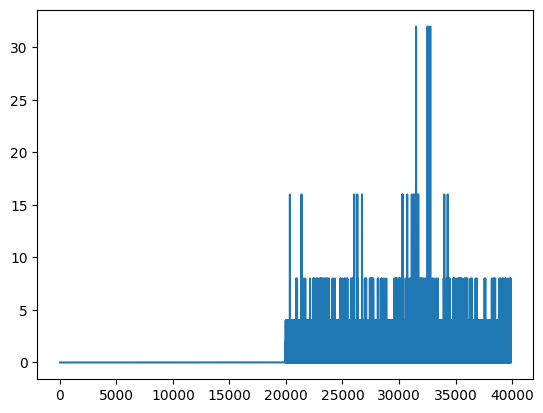

In [148]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# 读取CSV文件
file_path = 'D:\\QML\\QML_Cliiford\\samples_no_coeff.csv'
df = pd.read_csv(file_path)


# 进行正态归一化
# 假设数据列名为 'value'，如果列名不是这个，需要修改下面的代码
column_name = df.columns[0]
list_=list(df[column_name])
print(list_)
plt.plot(list_)
print(sorted(list_))

In [149]:
from itertools import product

def generate_strings(n):
    # 使用itertools.product生成所有长度为n的I和Z的组合
    combinations = product('IZ', repeat=n)
    # 将生成的组合转换为字符串并存储在列表中
    result = [''.join(combination) for combination in combinations]
    return result

In [150]:
print(generate_strings(4))

['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ']


In [144]:
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    print(min_val,max_val)
    return [(x - min_val) / (max_val - min_val) for x in lst]


In [145]:
normi_list=normalize(list_)

0.0 0.015625


In [142]:
print(normi_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

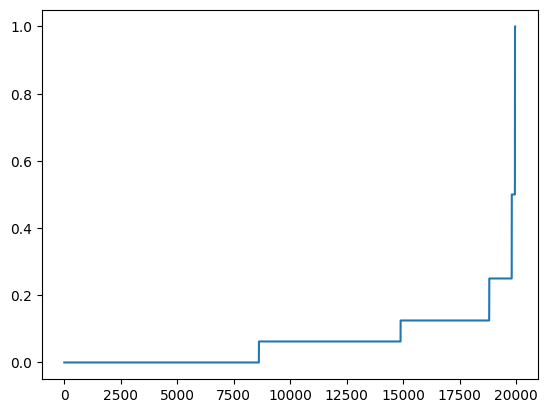

In [143]:
plt.plot(normi_list)